<a href="https://colab.research.google.com/github/cuongdq9131/demo-app/blob/master/%5Bpatched%5D_stock_direction_All_ticker_0908_runok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Imports

In [ ]:
%pip install optuna
import os
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import glob
from copy import deepcopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.9 MB/s eta 0:00:00


## 2. Load data & feature engineering

In [ ]:
def create_target(df, pct=0.07, n_ahead=5):
    df = df.copy()
    df = df.sort_values('time').reset_index(drop=True)
    df['future_close'] = df['close'].shift(-n_ahead)
    # Only assign targets where we have future data
    df['target'] = 0
    df.loc[df['future_close'] > df['close'] * (1 + pct), 'target'] = 1
    df.loc[df['future_close'] < df['close'] * (1 - pct), 'target'] = -1
    # Set target to NaN where future_close is NaN (i.e., last n_ahead rows)
    df.loc[df['future_close'].isna(), 'target'] = np.nan
    df['target'] = df['target'].astype('Int64')  # Allows for NaNs if needed
    return df
def add_smc_features(df, swing_n=3, vol_window=20, vol_z=2, ma_short=10, ma_long=30):
    df = df.copy()
    # 1) Causal swing highs/lows (past-only)
    # Pivot high at t if high_t is the max of the last (swing_n+1) highs
    df['swing_high'] = (
        df['high']
        .rolling(window=swing_n+1, min_periods=swing_n+1)
        .apply(lambda x: 1.0 if x[-1] == np.max(x) else 0.0, raw=True)
        .fillna(0)
        .astype(int)
    )
    # Pivot low at t if low_t is the min of the last (swing_n+1) lows
    df['swing_low'] = (
        df['low']
        .rolling(window=swing_n+1, min_periods=swing_n+1)
        .apply(lambda x: 1.0 if x[-1] == np.min(x) else 0.0, raw=True)
        .fillna(0)
        .astype(int)
    )

    # 2) Order blocks: volume spike + price up (causal)
    vol_mean = df['volume'].rolling(vol_window, min_periods=1).mean()
    vol_std = df['volume'].rolling(vol_window, min_periods=1).std(ddof=0)
    df['vol_zscore'] = (df['volume'] - vol_mean) / (vol_std.replace(0, np.nan))
    df['order_block'] = ((df['vol_zscore'] > 1.5) & (df['close'] > df['close'].shift(1))).astype(int)

    # 3) Liquidity sweeps (causal)
    df['liquidity_sweep_high'] = ((df['high'] > df['high'].shift(1)) & (df['close'] < df['high'])).astype(int)
    df['liquidity_sweep_low']  = ((df['low']  < df['low'].shift(1))  & (df['close'] > df['low'])).astype(int)

    # 4) BOS / CHOCH (causal)
    df['bos']   = ((df['close'] > df['high'].shift(1)) | (df['close'] < df['low'].shift(1))).astype(int)
    df['choch'] = ((df['swing_high'].shift(1) == 1) & (df['close'] < df['low'].shift(2))).astype(int)

    # 5) Fair Value Gaps (causal, 3-candle pattern)
    # Bullish FVG if current low > high from two bars ago
    df['fvg_up']   = (df['low']  > df['high'].shift(2)).astype(int)
    # Bearish FVG if current high < low from two bars ago
    df['fvg_down'] = (df['high'] < df['low'].shift(2)).astype(int)

    # 6) Volume climax
    df['volume_zscore'] = (df['volume'] - vol_mean) / (vol_std.replace(0, np.nan))
    df['volume_climax'] = (df['volume_zscore'].abs() > vol_z).astype(int)

    # 9) RSI
    def calc_rsi(series, period=14):
        delta = series.diff()
        up = delta.clip(lower=0)
        down = (-delta).clip(lower=0)
        avg_gain = up.rolling(window=period, min_periods=1).mean()
        avg_loss = down.rolling(window=period, min_periods=1).mean()
        rs = avg_gain / (avg_loss + 1e-9)
        return 100 - (100 / (1 + rs))
    df['rsi_14'] = calc_rsi(df['close'], 14)

    return df

def prepare_stock_data(
    stock_files,
    add_features_func,
    create_target_func,
    smc=True,
    target_kwargs=None
):
    """
    Reads stock files, adds features (optionally SMC), creates targets, returns:
      - df_full: all rows/features (even last bar)
      - df_ml: only rows with all features+target (for ML)
    """

    dfs_full = []
    dfs_ml = []
    if target_kwargs is None:
        target_kwargs = {}

    for fname, ticker in stock_files:
        df = pd.read_csv(fname)
        df['time'] = pd.to_datetime(df['epoch'], unit='s')
        df['ticker'] = ticker

        # 1. Add SMC or custom features
        if smc:
            df = add_features_func(df)
        else:
            df = df.copy()

        # 2. Create target (ALWAYS returns a DataFrame with same index)
        df_target = create_target_func(df, **target_kwargs)
        if 'target' in df.columns:
            df = df.drop(columns=['target'])
        df['target'] = df_target['target']

        # 3. Append all rows for full plotting/inference
        dfs_full.append(df.copy())

        # 4. For ML: drop rows with any NaN in features or target (for pure training!)
        # We'll auto-detect feature columns (besides time/ticker/epoch/target)
        feature_cols = [col for col in df.columns if col not in ['time', 'ticker', 'epoch', 'target']]
        # After feature creation, BEFORE dropna:
        df[feature_cols] = df.groupby('ticker')[feature_cols].transform(lambda g: g.ffill())

      # Then proceed with:
        df_ml_local = df.dropna(subset=['target'])  # target must not be NaN
        dfs_ml.append(df_ml_local)

    df_full = pd.concat(dfs_full, ignore_index=True)
    df_ml = pd.concat(dfs_ml, ignore_index=True)
    return df_full, df_ml



def fetch_and_save_data(ticker: str, start_date: str, end_date: str, interval: str):

    try:
        quote = Quote(symbol=ticker)
        df = quote.history(
            start=start_date,
            end=end_date,
            interval=interval
        )

        if df.empty:
            return pd.DataFrame()   # Return empty DataFrame if no data

        if "volume" in df.columns:
            df["volume"] = df["volume"].astype("int64")

        df["time"] = pd.to_datetime(df["time"], errors="coerce")
        df["epoch"] = df["time"].astype("int64") // 10**9

        return df   # <--- This is new! Returns DataFrame

    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
        return pd.DataFrame()   # Return empty DataFrame on error


def universal_stock_prepare_data(
    selected_ticker,
    stock_files=None,
    add_features_func=None,
    create_target_func=None,
    smc=True,
    target_kwargs=None,
    fetch_func=None,        # your custom data fetch function
    fetch_args=None         # dict: {start_date, end_date, interval}
):
    """
    Prepares df_full and df_ml for a given ticker, from stock_files (CSV) or dynamic fetch.
    - If ticker in stock_files, reads CSV and processes as usual.
    - If not, fetches data and applies feature/target engineering.
    Returns: df_full_ticker, df_ml_ticker
    """
    import pandas as pd

    if target_kwargs is None:
        target_kwargs = {}

    # Try to find the ticker in stock_files
    in_list = False
    df_full_ticker = None
    df_ml_ticker = None

    if stock_files is not None:
        for fname, ticker in stock_files:
            if ticker == selected_ticker:
                # --- 1. Load from CSV as usual ---
                df = pd.read_csv(fname)
                df['time'] = pd.to_datetime(df['epoch'], unit='s')
                df['ticker'] = ticker

                if smc:
                    df = add_features_func(df)
                else:
                    df = df.copy()

                df_target = create_target_func(df, **target_kwargs)
                if 'target' in df.columns:
                    df = df.drop(columns=['target'])
                df['target'] = df_target['target']

                # Fill features for all rows for plotting/prediction
                feature_cols = [col for col in df.columns if col not in ['time', 'ticker', 'epoch', 'target']]
                df[feature_cols] = df.groupby('ticker')[feature_cols].transform(lambda g: g.ffill())

                # df_full: all rows
                df_full_ticker = df.copy()
                # df_ml: only rows with valid target
                df_ml_ticker = df.dropna(subset=['target']).copy()

                in_list = True
                break

    if not in_list:
        # --- 2. Fetch data for the ticker not in stock_files ---
        if fetch_func is None or add_features_func is None or create_target_func is None or fetch_args is None:
            raise ValueError("Must provide fetch_func, add_features_func, create_target_func, and fetch_args for dynamic ticker.")
        # Fetch and process data
        df = fetch_func(selected_ticker, **fetch_args)
        if df is None or df.empty:
            raise ValueError(f"No data found for ticker {selected_ticker}")

        df['time'] = pd.to_datetime(df['epoch'], unit='s', errors='coerce')
        df['ticker'] = selected_ticker

        if smc:
            df = add_features_func(df)
        else:
            df = df.copy()

        df_target = create_target_func(df, **target_kwargs)
        if 'target' in df.columns:
            df = df.drop(columns=['target'])
        df['target'] = df_target['target']

        feature_cols = [col for col in df.columns if col not in ['time', 'ticker', 'epoch', 'target']]
        df[feature_cols] = df.groupby('ticker')[feature_cols].transform(lambda g: g.ffill())

        df_full_ticker = df.copy()
        df_ml_ticker = df.dropna(subset=['target']).copy()

    return df_full_ticker, df_ml_ticker


## 3. Per-ticker split: train/test for each ticker, then concat

In [ ]:
selected_ticker = 'LPB'
stock_files = [
    # ('DGC_2020-01-01_2025-08-07.csv', 'DGC'),
    # ('HCM_2020-01-01_2025-08-07.csv', 'HCM'),
    # ('HDG_2020-01-01_2025-08-07.csv', 'HDG'),
    # ('HPG_2020-01-01_2025-08-07.csv', 'HPG'),
    # ('HDC_2020-01-01_2025-08-07.csv', 'HDC'),
    # ('KBC_2020-01-01_2025-08-07.csv', 'KBC'),
    # ('KDH_2020-01-01_2025-08-07.csv', 'KDH'),
    # ('MBS_2020-01-01_2025-08-07.csv', 'MBS'),
    # ('MBB_2020-01-01_2025-08-07.csv', 'MBB'),
    # ('MSN_2020-01-01_2025-08-07.csv', 'MSN'),
    # ('NLG_2020-01-01_2025-08-07.csv', 'NLG'),
    # ('NHA_2020-01-01_2025-08-07.csv', 'NTL'),
    # ('PDR_2020-01-01_2025-08-07.csv', 'PDR'),
    # ('SZC_2020-01-01_2025-08-07.csv', 'SZC'),
    # ('SSI_2020-01-01_2025-08-07.csv', 'SSI'),
    # ('VCI_2020-01-01_2025-08-07.csv', 'VCI'),
    # ('VND_2020-01-01_2025-08-07.csv', 'VND'),
    ('ABB_2020-01-04_2025-08-08.csv', 'ABB'),
    ('AGR_2020-01-04_2025-08-08.csv', 'AGR'),
    ('BIC_2020-01-04_2025-08-08.csv', 'BIC'),
    ('BSI_2020-01-04_2025-08-08.csv', 'BSI'),
    ('CEO_2020-01-04_2025-08-08.csv', 'CEO'),
    ('CSV_2020-01-04_2025-08-08.csv', 'CSV'),
    ('CTS_2020-01-04_2025-08-08.csv', 'CTS'),
    ('DIG_2020-01-04_2025-08-08.csv', 'DIG'),
    ('DTD_2020-01-04_2025-08-08.csv', 'DTD'),
    ('FRT_2020-01-04_2025-08-08.csv', 'FRT'),
    ('FTS_2020-01-04_2025-08-08.csv', 'FTS'),
    ('HAH_2020-01-04_2025-08-08.csv', 'HAH'),
    ('LPB_2020-01-04_2025-08-08.csv', 'LPB'),
    ('NKG_2020-01-04_2025-08-08.csv', 'NKG'),
    ('TPB_2020-01-04_2025-08-08.csv', 'TPB'),
    ('TIG_2020-01-04_2025-08-08.csv', 'TIG'),
    ('LPB_2020-01-04_2025-08-08.csv', 'LPB'),
    ('VGS_2020-01-04_2025-08-08.csv', 'VGS'),
    ('VHC_2020-01-04_2025-08-08.csv', 'VHC'),
]
fetch_args = {'start_date': '2020-01-01', 'end_date': '2025-08-01', 'interval': '1W'}

# Extract the list of tickers from stock_files
tickers_in_list = [ticker for _, ticker in stock_files]

if selected_ticker in tickers_in_list:
    df_full, df_ml = universal_stock_prepare_data(
    selected_ticker=selected_ticker,
    stock_files=stock_files,
    add_features_func=add_smc_features,
    create_target_func=create_target,
    smc=True,
    target_kwargs={'pct': 0.07, 'n_ahead': 5}
)

else:
    fetch_args = {'start_date': '2020-01-01', 'end_date': '2025-08-01', 'interval': '1wk'}
    df_full, df_ml = universal_stock_prepare_data(
    selected_ticker=selected_ticker,
    stock_files=stock_files,
    add_features_func=add_smc_features,
    create_target_func=create_target,
    smc=True,
    target_kwargs={'pct': 0.05, 'n_ahead': 1},
    fetch_func=fetch_and_save_data,   # your custom function, returns DataFrame
    fetch_args=fetch_args
)
df_ml_ticker = df_ml[df_ml['ticker'] == selected_ticker].copy()

feature_cols = [
    'swing_high', 'swing_low',
    'order_block', 'liquidity_sweep_high', 'liquidity_sweep_low',
    'bos', 'choch', 'fvg_up', 'fvg_down',
    'volume_climax'
]
features = feature_cols
target_col = 'target'

#f_ml_ticker = df_ml[df_ml['ticker'] == selected_ticker].copy().reset_index(drop=True)
df_ml_ticker = df_ml[df_ml['ticker'] == selected_ticker].copy()
df_full_ticker = df_full[df_full['ticker'] == selected_ticker].copy()

#prePARE
feature_candidates = [
    # SMC
    'swing_high', 'swing_low', 'order_block', 'liquidity_sweep_high', 'liquidity_sweep_low',
    'bos', 'choch', 'fvg_up', 'fvg_down', 'volume_climax','rsi_14',
    # Trend/Momentum/Returns
    #'ma_diff', 'momentum_5', 'momentum_10', 'return_1', 'return_5', 'return_10',
    # Add more TA features if you have them!
    # Price/volume lags
    'close', 'volume',
]

# 2. Create price lag features (if not present)
#  for lag in [1, 2, 3]:
#     df_ml_ticker[f'close_lag{lag}'] = df_ml_ticker['close'].shift(lag)

# 3. Drop NA rows from lags
df_ml_ticker = df_ml_ticker.dropna(subset=feature_candidates).reset_index(drop=True)

# 4. Quick feature importance check
X = df_ml_ticker[feature_candidates]
y = df_ml_ticker['target']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=feature_candidates).sort_values(ascending=False)

print(importances.head(10))

# 5. (Optional) Remove highly correlated features
corr_matrix = df_ml_ticker[feature_candidates].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Highly correlated features to drop: {to_drop}")

# 6. Select your final optimized feature set
optimized_features = list(importances.head(12).index)  # Top 12 important, or adjust number

X = df_ml_ticker[optimized_features]
y = df_ml_ticker['target']

split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

close                   0.303087
rsi_14                  0.267464
volume                  0.250484
bos                     0.026236
liquidity_sweep_low     0.024628
liquidity_sweep_high    0.022671
swing_high              0.021393
swing_low               0.020853
fvg_down                0.015001
volume_climax           0.013753
dtype: float64
Highly correlated features to drop: []


## 4. Scale

In [ ]:
import joblib
import os
import optuna

from sklearn.model_selection import TimeSeriesSplit

from typing import Iterator, Tuple, Optional

class GroupedPurgedWalkForwardSplit:
    """
    Time-ordered, *group-aware* walk-forward CV with a purge gap.
    - Groups keep samples together (e.g., all tickers at the same timestamp).
    - Purge gap removes recent groups before validation to prevent leakage.
    - Train window can expand; you can cap it with max_train_group_size.
    """
    def __init__(self, n_splits: int = 5, group_gap: int = 0,
                 test_group_size: int = 1, min_train_groups: int = 30,
                 max_train_group_size: Optional[int] = None):
        self.n_splits = int(n_splits)
        self.group_gap = int(group_gap)
        self.test_group_size = int(test_group_size)
        self.min_train_groups = int(min_train_groups)
        self.max_train_group_size = max_train_group_size

    def split(self, X, y=None, groups=None) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        if groups is None:
            raise ValueError("GroupedPurgedWalkForwardSplit requires 'groups' (e.g., timestamps).")
        g = pd.Series(groups).copy()
        # ensure time order by sorting unique groups
        uniq = pd.Index(np.unique(g.values)).sort_values()
        n_groups = len(uniq)
        if n_groups < (self.min_train_groups + self.group_gap + self.test_group_size):
            raise ValueError("Not enough groups for the requested split sizes.")
        # candidate test starts
        first_test_start = self.min_train_groups
        last_test_start = n_groups - self.test_group_size
        candidate = list(range(first_test_start, last_test_start + 1))
        if self.n_splits < len(candidate):
            # pick evenly spaced test starts
            idxs = np.linspace(0, len(candidate)-1, self.n_splits).round().astype(int)
            test_starts = [candidate[i] for i in idxs]
        else:
            test_starts = candidate

        # map group -> row indices
        group_to_rows = {grp: g.index[g.values == grp].to_numpy() for grp in uniq}
        for t_start in test_starts:
            t_end = t_start + self.test_group_size
            # purge gap between train and test
            train_end = max(0, t_start - self.group_gap)
            train_start = 0 if self.max_train_group_size is None else max(0, train_end - self.max_train_group_size)
            if (train_end - train_start) < self.min_train_groups:
                train_start = max(0, train_end - self.min_train_groups)

            train_groups = uniq[train_start:train_end]
            test_groups = uniq[t_start:t_end]

            train_idx = np.concatenate([group_to_rows[grp] for grp in train_groups]) if len(train_groups) else np.array([], dtype=int)
            test_idx  = np.concatenate([group_to_rows[grp] for grp in test_groups]) if len(test_groups) else np.array([], dtype=int)
            yield train_idx, test_idx

from sklearn.metrics import f1_score
from tensorflow.keras.models import load_model

 # 5. Scale features
feature_names_in_ = X.columns

          # 6. LightGBM hyperparameter search
      # from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
      # param_grid = {
      #         'num_leaves': [15, 31, 63],
      #         'n_estimators': [100, 200, 500],
      #         'learning_rate': [0.01, 0.05, 0.1],
      #         'min_child_samples': [5, 20, 50],
      #         'subsample': [0.8, 1.0]
      #     }

      #
# === Grouped Purged Walk-Forward CV (multi-ticker ready) ===
# Group by exact bar timestamp so ALL tickers at the same time fall in the same fold.
# For single-ticker training, this still works and behaves like purged TSS.
if 'time' in df_ml_ticker.columns:
    cv_groups = pd.to_datetime(df_ml_ticker['time']).values
else:
    cv_groups = pd.to_datetime(df_ml_ticker.index).values

CV_CFG = {
    "n_splits": 5,
    "group_gap": 5,         # purge 5 bar-groups between train and val
    "test_group_size": 250, # roughly size of each validation window (in bar-groups)
    "min_train_groups": 1000,  # require at least this many groups in the train window
    "max_train_group_size": None  # or cap the expanding window
}
cv = GroupedPurgedWalkForwardSplit(**CV_CFG)
# lgbm = lgb.LGBMClassifier()
      # grid = GridSearchCV(lgbm, param_grid, cv=tscv, scoring='f1_weighted', n_jobs=-1)
      # grid.fit(X_train_scaled, y_train)
      # lgbm_best = grid.best_estimator_



tscv = TimeSeriesSplit(n_splits=5)
y_for_lgb = y + 1  # Convert -1,0,1 to 0,1,2

def objective(trial):
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3,
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
    }
    scores = []
    for train_index, val_index in cv.split(X, groups=cv_groups):
            # Purge to avoid leakage around fold boundary
        purge = 5
        train_index = train_index[train_index < (val_index[0] - purge)]
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y_for_lgb.iloc[train_index], y_for_lgb.iloc[val_index]
        train_dataset = lgb.Dataset(X_train, label=y_train)
        val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)
        model = lgb.train(
            params,
            train_set=train_dataset,
            valid_sets=[val_dataset],
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )
        preds = model.predict(X_val)
        preds_class = np.argmax(preds, axis=1)
        f1 = f1_score(y_val, preds_class, average='weighted')
        scores.append(f1)
    return -np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Value (Mean -Weighted F1): {trial.value:.4f}")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train final model with best params
best_params = trial.params
best_params.update({
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 3,
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
})
lgbm_best = lgb.LGBMClassifier(**best_params)
lgbm_best.fit(X, y_for_lgb)

[I 2025-08-11 03:16:53,200] A new study created in memory with name: no-name-cd1d6033-a4a8-464e-8b97-e5935fb60b8e
[I 2025-08-11 03:16:54,844] Trial 0 finished with value: -0.8125432360409176 and parameters: {'learning_rate': 0.04336889692615866, 'num_leaves': 264, 'max_depth': 3, 'subsample': 0.7234716630807227, 'colsample_bytree': 0.8210732314220848, 'reg_alpha': 0.41788560381537965, 'reg_lambda': 0.15010647414196543}. Best is trial 0 with value: -0.8125432360409176.
[I 2025-08-11 03:16:56,607] Trial 1 finished with value: -0.8125432360409176 and parameters: {'learning_rate': 0.006067076602710571, 'num_leaves': 59, 'max_depth': 12, 'subsample': 0.7054914481160933, 'colsample_bytree': 0.6105944508582698, 'reg_alpha': 0.6464716296142113, 'reg_lambda': 0.5369238355001537}. Best is trial 0 with value: -0.8125432360409176.
[I 2025-08-11 03:16:57,314] Trial 2 finished with value: -0.8125432360409176 and parameters: {'learning_rate': 0.0438846816305066, 'num_leaves': 126, 'max_depth': 8, 'su

Best trial:
  Value (Mean -Weighted F1): -0.8160
  Best hyperparameters: 
    learning_rate: 0.038300275902604784
    num_leaves: 107
    max_depth: 12
    subsample: 0.678250600547481
    colsample_bytree: 0.8265128268947372
    reg_alpha: 0.6766522201264511
    reg_lambda: 0.18275684435928202


LGBMClassifier(colsample_bytree=0.8265128268947372,
               learning_rate=0.038300275902604784, max_depth=12,
               metric='multi_logloss', n_estimators=1000, n_jobs=-1,
               num_class=3, num_leaves=107, objective='multiclass',
               random_state=42, reg_alpha=0.6766522201264511,
               reg_lambda=0.18275684435928202, subsample=0.678250600547481,
               verbose=-1)

## 5.CACULATE AND PLOTTING

0.48


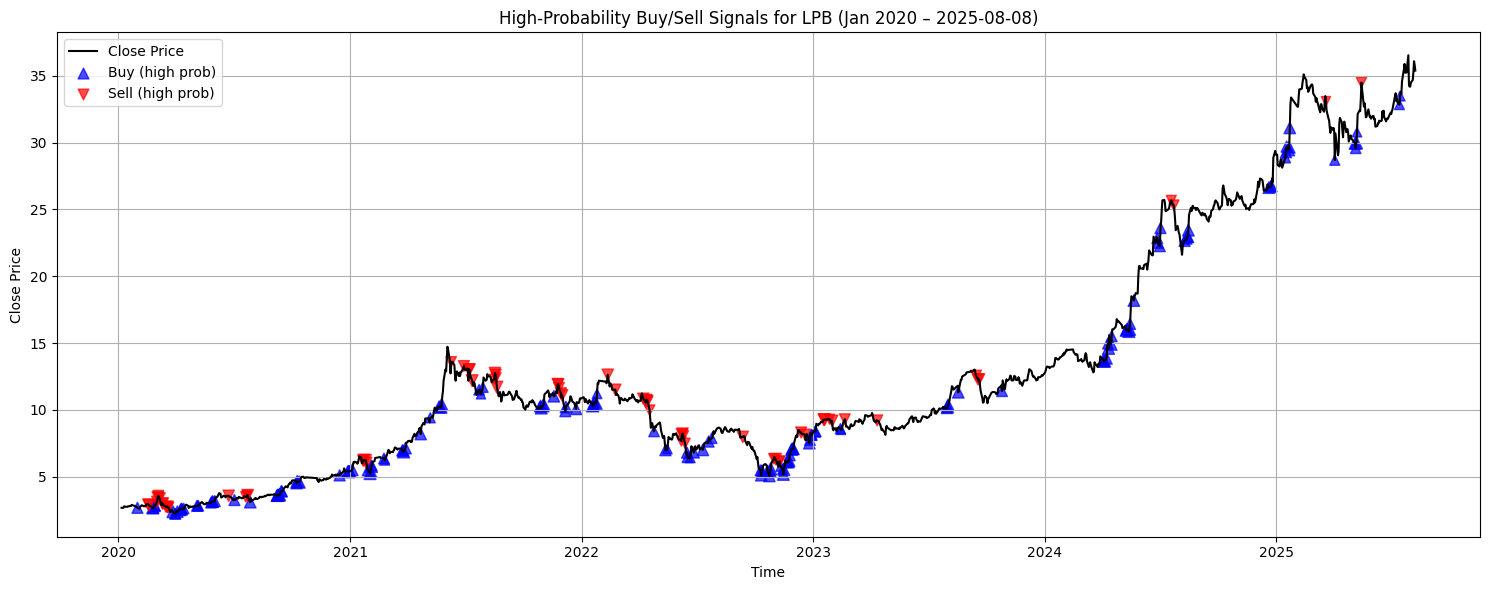

In [ ]:
import numpy as np
import pandas as pd

# Prepare ticker dummies if you use them
feature_cols_all = optimized_features.copy()
dummy_cols = [c for c in feature_names_in_ if c.startswith('ticker_')]
use_ticker_dummies = len(dummy_cols) > 0

if use_ticker_dummies:
    ticker_dummy_row = np.zeros(len(dummy_cols))
    if f'ticker_{selected_ticker}' in dummy_cols:
        ticker_dummy_row[dummy_cols.index(f'ticker_{selected_ticker}')] = 1
    ticker_dummy_mat = np.tile(ticker_dummy_row, (df_full_ticker.shape[0], 1))
    X_all = df_full_ticker[optimized_features].values
    X_all_full = np.hstack([X_all, ticker_dummy_mat])
    X_all_full_df = pd.DataFrame(X_all_full, columns=feature_names_in_)
else:
    X_all_full_df = df_full_ticker[optimized_features].copy()

# Add any missing columns (fill with 0)
for col in feature_names_in_:
    if col not in X_all_full_df.columns:
        X_all_full_df[col] = 0

# Drop any extra columns not in training
X_all_full_df = X_all_full_df[feature_names_in_]

# --- Now scale safely ---
X_all_scaled = X_all_full_df.values

# --- Predict for all bars ---
df_full_ticker['lgbm_pred'] = lgbm_best.predict(X_all_full_df)

    # Predict class probabilities for all samples
proba = lgbm_best.predict_proba(X_all_full_df)
class_order = lgbm_best.classes_  # should be [0, 1, 2] after Optuna

df_full_ticker['lgbm_pred'] = lgbm_best.predict(X_all_full_df)
df_full_ticker['lgbm_pred_proba'] = proba.max(axis=1)
df_full_ticker['lgbm_pred_class'] = class_order[proba.argmax(axis=1)]


# Store all class probabilities, regardless of class_order
df_full_ticker['lgbm_pred_proba_sell'] = proba[:, 0]  # class 0 (original -1)
df_full_ticker['lgbm_pred_proba_hold'] = proba[:, 1]  # class 1 (original 0)
df_full_ticker['lgbm_pred_proba_buy']  = proba[:, 2]  # class 2 (original 1)
import matplotlib.pyplot as plt
import joblib

df_full_ticker['lgbm_pred'] = lgbm_best.predict(X_all_full_df)
# # Filter for period (change dates as needed)
latest_date = df_full['time'].max()
df_vis = df_full_ticker[(df_full_ticker['time'] >= '2020-01-01') & (df_full_ticker['time'] <= latest_date)].copy()

# === Optimize probability threshold tau using validation Sharpe (after costs) ===
def _optimize_tau(prob_buy, prob_sell, close, cost_per_trade=0.0005):
    rets = close.pct_change().shift(-1)
    taus = np.linspace(0.0, 0.5, 26)
    best_tau, best_sharpe = 0.0, -np.inf
    for tau in taus:
        raw_sig = np.where(prob_buy - prob_sell > tau, 1,
                  np.where(prob_sell - prob_buy > tau, -1, 0)).astype(float)
        pos = pd.Series(raw_sig, index=close.index).ffill().fillna(0.0)
        trades = pos.diff().abs().fillna(0.0)
        pnl = pos.shift(1) * rets - cost_per_trade * trades
        # Avoid tiny std
        if pnl.std(ddof=0) > 1e-9:
            sharpe = pnl.mean() / (pnl.std(ddof=0) + 1e-12)
            if sharpe > best_sharpe:
                best_sharpe, best_tau = sharpe, tau
    return best_tau, best_sharpe

df_tau = df_full_ticker.dropna(subset=['lgbm_pred_proba_buy','lgbm_pred_proba_sell','close']).copy()
best_tau, best_tau_sharpe = _optimize_tau(
    df_tau['lgbm_pred_proba_buy'].values,
    df_tau['lgbm_pred_proba_sell'].values,
    df_tau['close']
)
threshold = float(best_tau)
print(threshold)
#threshold = 0.5

# Build volatility-targeted positions from probabilities and chosen tau
df_trading = df_vis.copy() if 'df_vis' in globals() else df_full_ticker.copy()

#buy_signals1 = df_vis[(df_vis['lgbm_pred'] == 2) & (df_vis['lgbm_pred_proba_buy'] > threshold)]
#sell_signals = df_vis[(df_vis['lgbm_pred'] == 0) & (df_vis['lgbm_pred_proba_sell'] > threshold)]
buy_signals1 = df_vis[
    (df_vis['lgbm_pred'] == 2) &
    (df_vis['lgbm_pred_proba_buy'] > threshold) &
    (df_vis['rsi_14'] <= 75)
]
sell_signals = df_vis[
    (df_vis['lgbm_pred'] == 0) &
    (df_vis['lgbm_pred_proba_sell'] > threshold) &
    (df_vis['rsi_14'] >= 35)
]
plt.close('all')
plt.figure(figsize=(15, 6))
plt.plot(df_vis['time'], df_vis['close'], label='Close Price', color='black')

# Plot high-confidence buy signals (marker size reflects probability)
plt.scatter(buy_signals1['time'],buy_signals1['close'],label='Buy (high prob)',marker='^',color='blue',s=80 * buy_signals1['lgbm_pred_proba_buy'],
alpha=0.7)

# Plot high-confidence sell signals
plt.scatter(sell_signals['time'],sell_signals['close'],label='Sell (high prob)',marker='v',color='red',s=80 * sell_signals['lgbm_pred_proba_sell'],alpha=0.7)

plt.title(f"High-Probability Buy/Sell Signals for {selected_ticker} (Jan 2020 – {latest_date.date()})")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()